In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Import Libraries***

In [2]:
import os
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

***Load Training and Testing Brain Tumour Images***

In [3]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Odunola Thesis/Brain Tumor MRI Dataset/Training'
test_path = '/content/drive/MyDrive/Colab Notebooks/Odunola Thesis/Brain Tumor MRI Dataset/Testing'

***Count the number of MRI Images in the training and testing set***

In [4]:
def get_number(path):
  if not os.path.exists(path):
    return 0
  count = 0

  for current_path, dirs, files in os.walk(path):
    for dr in dirs:
      count += len(glob.glob(os.path.join(current_path,dr + "/*")))
  return count

In [5]:
training_images = get_number(train_path)
testing_images = get_number(test_path)
num_classes = len(glob.glob(train_path + "/*"))

print("Number of classes is", num_classes)
print("Number of training samples is", training_images)
print("Number of testing samples is", testing_images)

Number of classes is 4
Number of training samples is 5722
Number of testing samples is 1311


***Data Augmentation***

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    brightness_range = [0.8, 1.2],
    channel_shift_range = 50.0
    )

test_datagen = ImageDataGenerator(
    rescale=1./255
    )

In [7]:
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (img_width, img_height),
    batch_size = batch_size)

test_generator = test_datagen.flow_from_directory(
    test_path,
    shuffle = False,
    target_size = (img_width, img_height),
    batch_size = batch_size)

# Get x_train and y_train
x_train, y_train = train_generator.next()

# Get x_test and y_test
x_test, y_test = test_generator.next()

Found 5722 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


***Create Transfer Learning Model***

In [8]:
# Load pre-trained InceptionV3 model without the top classification layers
base_model = InceptionV3(
    weights = 'imagenet',
    include_top = False,
    input_shape = input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add more trainable layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)  # Additional dense layer
x = Dense(256, activation='relu')(x)  # Additional dense layer
predictions = Dense(4, activation='softmax')(x)  # Four classes: no_tumour, pituitary_tumour, meningioma_tumour, glioma_tumour

87910968/87910968 [==============================] - 0s 0us/step


In [9]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # For multi-class classification
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [10]:
best_model_path = '/content/drive/MyDrive/Colab Notebooks/Odunola Thesis/best_model_inception.h5'

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True)

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 50,  # You can set a high number of epochs
    callbacks = [early_stopping, model_checkpoint]  # Pass both callbacks
)

Epoch 1/50
178/178 [==============================] - ETA: 0s - loss: 0.6193 - accuracy: 0.7645

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - 1595s 9s/step - loss: 0.6193 - accuracy: 0.7645 - val_loss: 0.6677 - val_accuracy: 0.7437
Epoch 2/50
178/178 [==============================] - 122s 685ms/step - loss: 0.4529 - accuracy: 0.8348 - val_loss: 0.5330 - val_accuracy: 0.7875
Epoch 3/50
178/178 [==============================] - 125s 703ms/step - loss: 0.3905 - accuracy: 0.8569 - val_loss: 0.4441 - val_accuracy: 0.8211
Epoch 4/50
178/178 [==============================] - 125s 701ms/step - loss: 0.3786 - accuracy: 0.8566 - val_loss: 0.4161 - val_accuracy: 0.8414
Epoch 5/50
178/178 [==============================] - 122s 684ms/step - loss: 0.3490 - accuracy: 0.8699 - val_loss: 0.4173 - val_accuracy: 0.8359
Epoch 6/50
178/178 [==============================] - 124s 698ms/step - loss: 0.3432 - accuracy: 0.8749 - val_loss: 0.3549 - val_accuracy: 0.8687
Epoch 7/50
178/178 [==============================] - 120s 677ms/step - loss: 0.3195 - accuracy: 0.8793 - val_loss: 0.4273 - val_accuracy

In [12]:
# Load the best model
best_model = tf.keras.models.load_model(best_model_path)

In [13]:
# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

41/41 [==============================] - 11s 238ms/step - loss: 0.3239 - accuracy: 0.8764
Test Accuracy: 0.8764302134513855


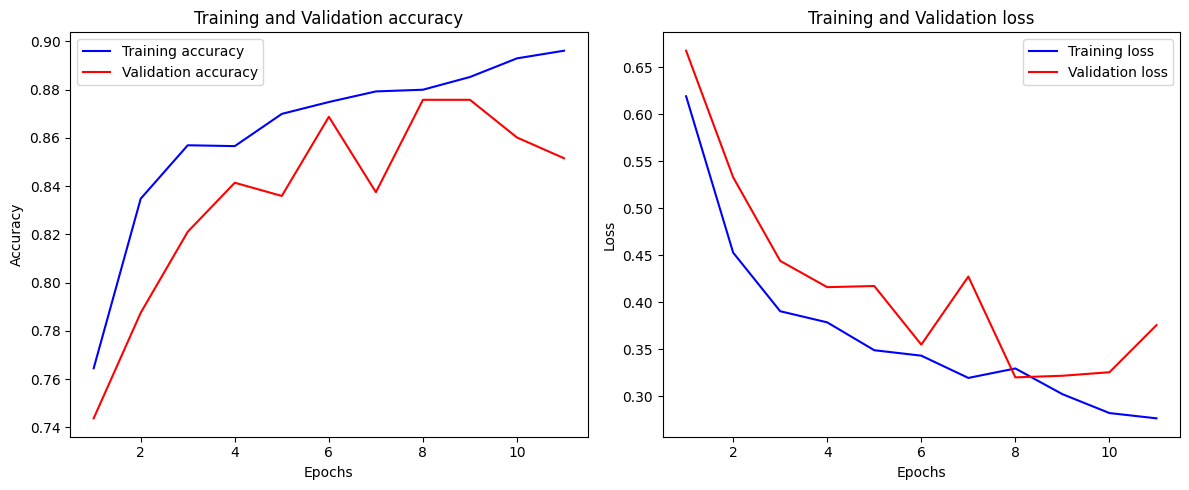

In [14]:
import matplotlib.pyplot as plt

# Assuming you have the history object already available
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting Training and Validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation loss
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Adjust the layout for better appearance
plt.show()

In [15]:
Classes = ['Glioma', 'Meningioma', 'No Tumour', 'Pituitary']

In [17]:
from sklearn.metrics import classification_report,confusion_matrix
y_test = test_generator.classes

# predicting our model with test dataset i.e. unseen dataset
pred = model.predict(test_generator, testing_images//batch_size+1,verbose=1,).argmax(axis=1)
#print(y_test)
print(pred)
#Classification report of every label
print(classification_report(y_test, pred, target_names = Classes))

41/41 [==============================] - 8s 166ms/step
[0 0 0 ... 3 3 3]
              precision    recall  f1-score   support

      Glioma       0.91      0.83      0.86       300
  Meningioma       0.77      0.76      0.77       306
   No Tumour       0.94      0.93      0.93       405
   Pituitary       0.88      0.96      0.92       300

    accuracy                           0.88      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.88      0.88      0.88      1311



In [18]:
correct = 0
incorrect = 0
for i in range(len(y_test)):

    #print("Test Sample is: ", y_test[i], "while predicted sample is: ", pred[i])

    if y_test[i] != pred[i]:
        incorrect += 1
    else:
        correct += 1

print('Total number of test cases', ((len(y_test))))
print('Number of correct predictions', correct)
print('Number of incorrect predictions', incorrect)

Total number of test cases 1311
Number of correct predictions 1149
Number of incorrect predictions 162


***Plot Confusion Matrix***

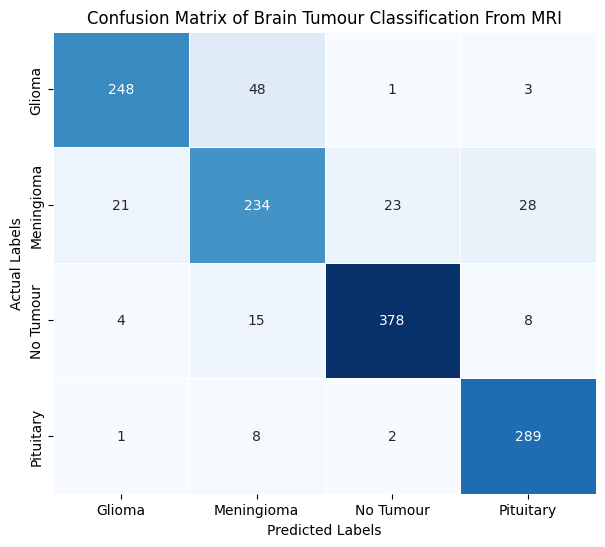

In [20]:
import pandas as pd
import seaborn as sn

# Create a confusion matrix
conf_mat = confusion_matrix(y_test, pred)

# Create a DataFrame from the confusion matrix
conf_df = pd.DataFrame(conf_mat, columns = Classes, index = Classes)

# Plot the confusion matrix using seaborn with annotated actual and predicted labels
plt.figure(figsize = (7, 6))
plt.title('Confusion Matrix of Brain Tumour Classification From MRI')
sn.heatmap(conf_df, fmt = "d", cmap = "Blues", annot = True, cbar = False, linewidths = .5)

# Add x and y axis labels
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

plt.show()